In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
from ecoevocrm.consumer_resource_system import *
from ecoevocrm.landscapes import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg
import ecoevocrm.strain_pool

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

----

## Model parameters

### Traits

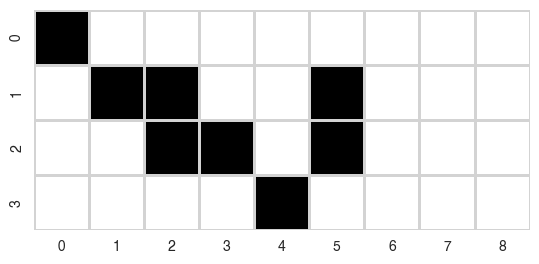

In [4]:
                       # h  h  h  h  h   t   m  m  m
traits_init = np.array([[1, 0, 0, 0, 0,  0,  0, 0, 0],   # pf|A
                        [0, 1, 1, 0, 0,  1,  0, 0, 0],   # pc|A
                        [0, 0, 1, 1, 0,  1,  0, 0, 0],   # pc|B
                        [0, 0, 0, 0, 1,  0,  0, 0, 0]])  # pf|B
viz.matrix_plot(traits_init, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [5]:
lineageIDs = ['A0', 'A1', 'B1', 'B0']

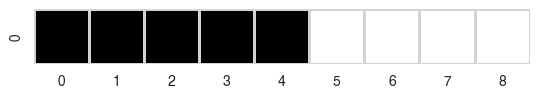

In [6]:
h = 1
consumption_rates = np.array([h, h, h, h, h, 0, 0, 0, 0])  # for all types
viz.matrix_plot(consumption_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

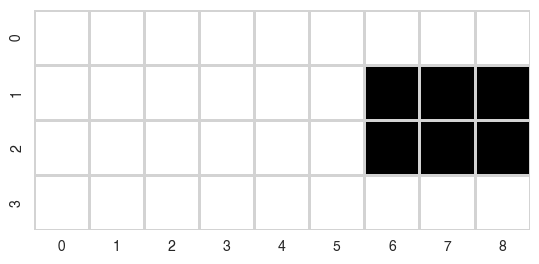

In [7]:
m = 1e-9  # TODO make get_dynamics_params work when mutation rate is 0, etc
mutation_rates = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],   # pf|A 
                           [0, 0, 0, 0, 0, 0, m, m, m],   # pc|A
                           [0, 0, 0, 0, 0, 0, m, m, m],   # pc|B
                           [0, 0, 0, 0, 0, 0, 0, 0, 0]])  # pf|B
viz.matrix_plot(mutation_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

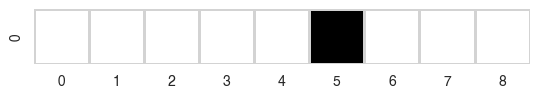

In [8]:
l = 1e-6
segregation_rates = np.array([0, 0, 0, 0, 0, l, 0, 0, 0])  # for all types
viz.matrix_plot(segregation_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

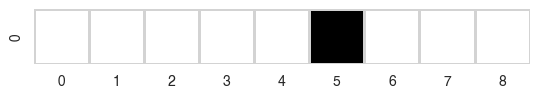

In [9]:
beta  = 1e-14
alpha = 1
transfer_rates_donor = np.array([0, 0, 0, 0, 0, beta, 0, 0, 0])  # for all types
transfer_rates_recip = np.array([0, 0, 0, 0, 0, alpha, 0, 0, 0])  # for all types
viz.matrix_plot(transfer_rates_donor, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)
viz.matrix_plot(transfer_rates_recip, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [10]:
linkage = {5: [6, 7, 8]}

In [11]:
                       #  segregant:  { attributes of segregant }
segregant_overrides = { '011000...': {'traits': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0]), 'mutation_rate': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])},
                        '001100...': {'traits': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0]), 'mutation_rate': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])} }

In [12]:
                         # transconjugant: { attributes of transconjugant }
transconjugant_overrides = { '100001...': {'traits': {'traits': [0, 1, 2, 3, 4], 'values': np.array([0, 1, 1, 0, 0])}},
                             '000011...': {'traits': {'traits': [0, 1, 2, 3, 4], 'values': np.array([0, 0, 1, 1, 0])}} }

In [13]:
N_init = np.ones(traits_init.shape[0])
N_init

array([1., 1., 1., 1.])

### Costs

In [14]:
cost_baseline = 0.1

In [15]:
N = 3
K = 0

In [16]:
landscape_hostA = NKLandscape(N=N, K=K, seed=67)
display(landscape_hostA.genotype_fitnesses)

{'000': 0.8040561057067969,
 '001': 0.7875642314646695,
 '010': 0.6465308714882542,
 '011': 0.6300389972461269,
 '100': 0.7389835549496024,
 '101': 0.7224916807074752,
 '110': 0.5814583207310596,
 '111': 0.5649664464889325}

In [17]:
landscape_hostB = NKLandscape(N=N, K=K, seed=858)
display(landscape_hostB.genotype_fitnesses)

{'000': 0.7315685487395694,
 '001': 0.6408336836099634,
 '010': 0.5257349589995871,
 '011': 0.435000093869981,
 '100': 0.6259306511991731,
 '101': 0.5351957860695671,
 '110': 0.4200970614591908,
 '111': 0.3293621963295848}

In [18]:
landscape = merge_landscapes(landscape_hostA.genotype_fitnesses, landscape_hostB.genotype_fitnesses, prefix_A='011001', prefix_B='001101')  # prefixes = traits for pc|A and pc|B

In [19]:
landscape.update({'100000000': max(landscape_hostA.genotype_fitnesses.values()),   # pf|A
                  '000010000': max(landscape_hostB.genotype_fitnesses.values())})  # pf|B

In [20]:
landscape

{'011001000': 0.8040561057067969,
 '011001001': 0.7875642314646695,
 '011001010': 0.6465308714882542,
 '011001011': 0.6300389972461269,
 '011001100': 0.7389835549496024,
 '011001101': 0.7224916807074752,
 '011001110': 0.5814583207310596,
 '011001111': 0.5649664464889325,
 '001101000': 0.7315685487395694,
 '001101001': 0.6408336836099634,
 '001101010': 0.5257349589995871,
 '001101011': 0.435000093869981,
 '001101100': 0.6259306511991731,
 '001101101': 0.5351957860695671,
 '001101110': 0.4200970614591908,
 '001101111': 0.3293621963295848,
 '100000000': 0.8040561057067969,
 '000010000': 0.7315685487395694}

### Environment

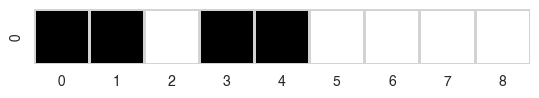

In [21]:
R_init = np.array([1, 1, 0, 1, 1, 0, 0, 0, 0])
viz.matrix_plot(R_init, vmin=0, vmax=1, cbar=False, linecolor='lightgray', linewidths=1)

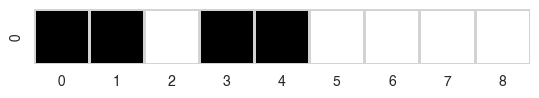

In [22]:
influx_rates = np.zeros(traits_init.shape[1])
influx_rates[R_init > 0] = 1
viz.matrix_plot(influx_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [23]:
decay_rates = 1

In [24]:
carrying_capacity = 1e9

## Initiallize model

In [25]:
community = Community(traits=traits_init, 
                      consumption_rate=consumption_rates, carrying_capacity=carrying_capacity, 
                      cost_landscape=landscape, cost_baseline=cost_baseline, 
                      mutation_rate=mutation_rates, segregation_rate=segregation_rates, transfer_rate_donor=transfer_rates_donor, transfer_rate_recip=transfer_rates_recip,
                      segregant_overrides=segregant_overrides, transconjugant_overrides=transconjugant_overrides,
                      segregation_linkage=linkage, transfer_linkage=linkage,
                      influx_rate=influx_rates, decay_rate=decay_rates,
                      lineageIDs=lineageIDs, lineageID_traits=[6, 7, 8],
                      N_init=N_init, R_init=R_init, seed=2)

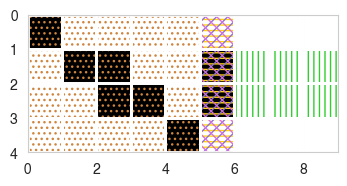

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
viz.attributes_plot(community.type_set, ax=ax)

In [27]:
# viz.attributes_plot(community.mutant_set)

In [28]:
# viz.attributes_plot(community.segregant_set)

In [29]:
# viz.attributes_plot(community.transconjugant_set)

## Run model

In [30]:
T_total = 1e6

In [31]:
community.run(T=T_total)

[ Mutant established at t=98.83 ]	001101000 --> 001101010
[ Segregant established at t=160.52 ]	011001000 --> 100000000
[ Transconjugant established at t=167.48 ]	001101000+100000000 --> 011001000
[ Transconjugant established at t=173.04 ]	001101000+100000000 --> 011001000
[ Transconjugant established at t=174.93 ]	001101000+100000000 --> 011001000
[ Transconjugant established at t=187.24 ]	011001000+100000000 --> 011001000
[ Mutant established at t=200.25 ]	001101010 --> 001101110
[ Segregant established at t=201.02 ]	011001000 --> 100000000
[ Segregant established at t=202.79 ]	011001000 --> 100000000
[ Mutant established at t=204.51 ]	001101010 --> 001101110
[ Mutant established at t=236.68 ]	001101010 --> 001101110
[ Mutant established at t=285.09 ]	001101010 --> 001101110
[ Mutant established at t=423.63 ]	011001000 --> 011001010
[ Mutant established at t=534.46 ]	001101110 --> 001101111
[ Mutant established at t=686.54 ]	001101110 --> 001101111
[ Mutant established at t=847.04 ]	

## Visualize results

In [32]:
cmapA = viz.lightdark_cmap('crimson', cmin=0.1, cmax=0.95, reverse=True)
cmapB = viz.lightdark_cmap('royalblue', cmin=0.1, cmax=0.95, reverse=True)
xconj_cmaps = [viz.lightdark_cmap(sns.color_palette('gnuplot2', as_cmap=True)(np.arange(0.45, 1.0, 0.1)[n-1]), cmin=0.1, cmax=0.95, reverse=True) for n in range(1, 7)]
# display(cmapA)
# display(cmapB)
# for cmap in xconj_cmaps: display(cmap)

In [33]:
type_colors, type_hatches = viz.type_styles_by_phylogeny(community.type_set, color_tags={'A': cmapA, 'B': cmapB, 't': {n+1: cmapT for n, cmapT in enumerate(xconj_cmaps)}}, hatch_tags={'s': '///', '0': '///'}, 
                                                         vmin=min(landscape.values()), vmax=max(landscape.values()) )

<AxesSubplot: >

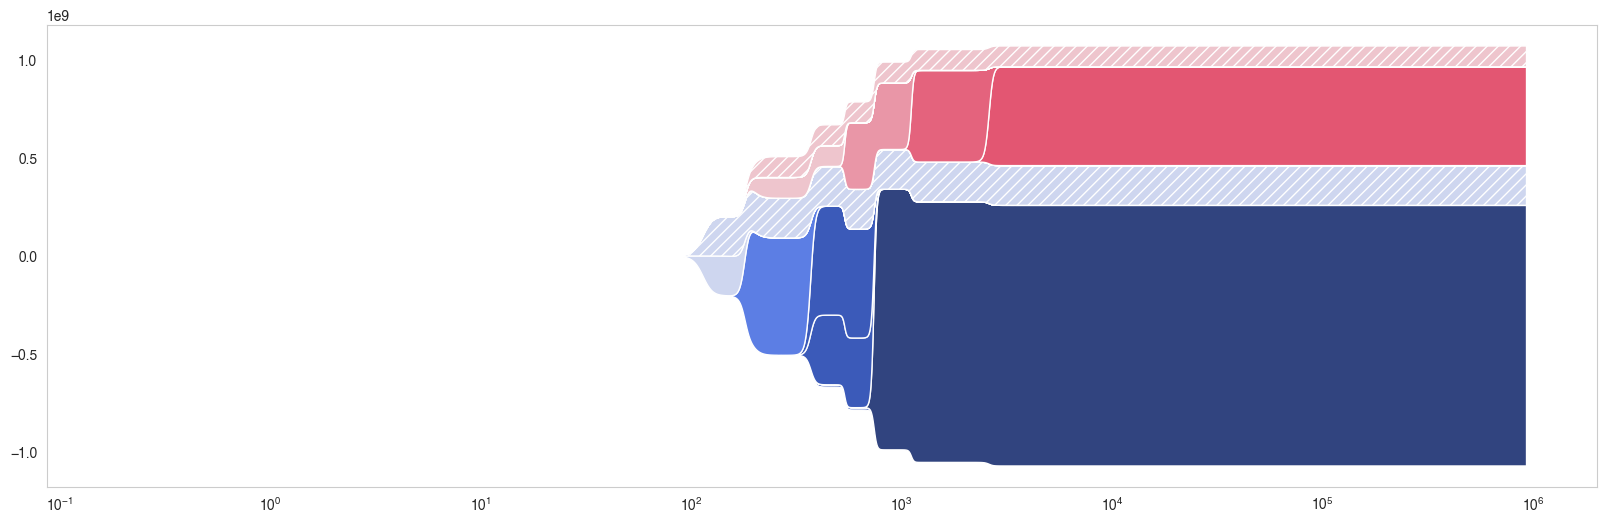

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
viz.abundance_plot(community, ax=ax, type_colors=type_colors, type_hatches=type_hatches, relative_abundance=False, stacked=True, baseline='sym', log_x_axis=True)

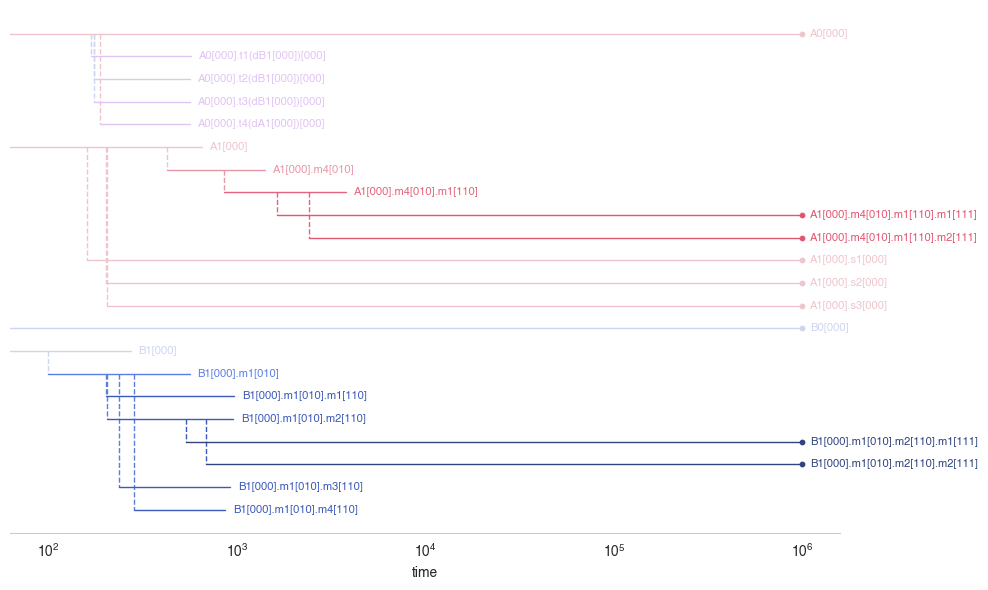

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
viz.phylogeny_plot(community, ax=ax, type_colors=type_colors, annot_lineageIDs=True, annot_traits=False, annot_extinct=True, annot_fontsize=8, log_x_axis=True)
# print(community.type_set.phylogeny)

In [36]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 6))
# viz.resource_plot(community, ax=ax, stacked=True, relative=False, log_x_axis=True, log_y_axis=False)

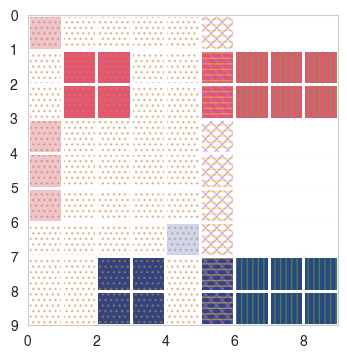

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
viz.attributes_plot(community.extant_type_set, ax=ax, type_colors=np.array(type_colors)[community.get_extant_type_indices()], annot_alpha=0.5)

In [38]:
community.N[community.extant_type_indices]

array([1.06125685e+08, 5.03833479e+08, 1.79724435e+03, 2.48474107e+02,
       5.08098595e+01, 5.55328264e+01, 2.02546683e+08, 1.32903460e+09,
       1.37295322e+03])

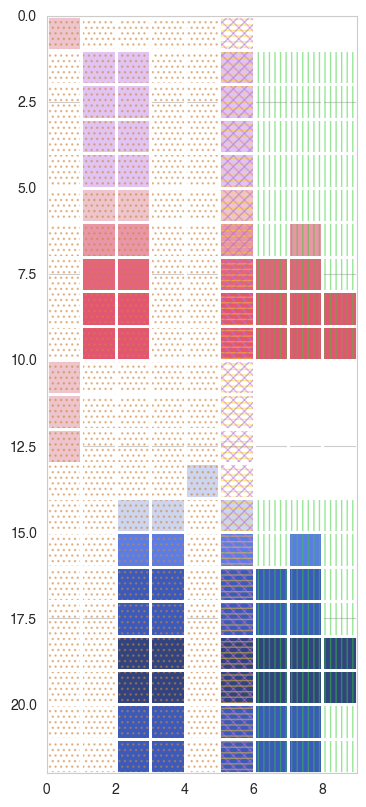

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
viz.attributes_plot(community.type_set, ax=ax, type_colors=type_colors, annot_alpha=0.5)